In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[INFO] loading images...")

#modify here
correct_mask_path = 'dataset\\correct_mask'
incorrect_mask_path = 'dataset\\incorrect_mask'
without_mask_path = 'dataset\\without_mask'

imagePaths1 = list(paths.list_images(correct_mask_path))
imagePaths2 = list(paths.list_images(incorrect_mask_path))
imagePaths3 = list(paths.list_images(without_mask_path))
imagePaths = [imagePaths1, imagePaths2, imagePaths3]

data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    for idx, path in enumerate(imagePath):
        #only use the first 1000 images
        if idx == 1000:
            break;
        # extract the class label from the filename
        label = path.split(os.path.sep)[-2]
        # load the input image (224x224) and preprocess it
        image = load_img(path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)

[INFO] loading images...


In [4]:
labels_backup = labels.copy()
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_backup)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

#convert them into numpy to be process
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [5]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [6]:
# compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
75/75 [==============================] - 29s 380ms/step - loss: 0.8577 - accuracy: 0.6413 - val_loss: 0.3405 - val_accuracy: 0.9050
Epoch 2/20
75/75 [==============================] - 27s 363ms/step - loss: 0.3705 - accuracy: 0.8687 - val_loss: 0.2122 - val_accuracy: 0.9383
Epoch 3/20
75/75 [==============================] - 27s 360ms/step - loss: 0.2815 - accuracy: 0.9038 - val_loss: 0.1734 - val_accuracy: 0.9483
Epoch 4/20
75/75 [==============================] - 26s 353ms/step - loss: 0.2345 - accuracy: 0.9254 - val_loss: 0.1498 - val_accuracy: 0.9533
Epoch 5/20
75/75 [==============================] - 27s 354ms/step - loss: 0.2053 - accuracy: 0.9233 - val_loss: 0.1307 - val_accuracy: 0.9617
Epoch 6/20
75/75 [==============================] - 27s 355ms/step - loss: 0.1829 - accuracy: 0.9354 - val_loss: 0.1146 - val_accuracy: 0.9617
Epoch 7/20
75/75 [==============================] - 27s 360ms/step - loss: 0.1709 - accuracy

In [7]:
#modify here
model_name = 'model'

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(f'{model_name}.h5', save_format="h5")

[INFO] evaluating network...
                precision    recall  f1-score   support

  correct_mask       0.98      0.95      0.97       200
incorrect_mask       0.96      0.98      0.97       200
  without_mask       1.00      1.00      1.00       200

      accuracy                           0.98       600
     macro avg       0.98      0.98      0.98       600
  weighted avg       0.98      0.98      0.98       600

[INFO] saving mask detector model...


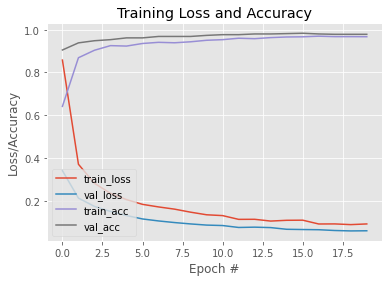

In [8]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot')

# Face Mask Detector

In [9]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils import paths
import numpy as np
import argparse
import cv2
import os

In [10]:
# load the serialized face detector model from disk
# modify here
face_det_fol_name = 'face_detector' #folder that have the face detector model

print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([face_det_fol_name, "deploy.prototxt"])
weightsPath = os.path.sep.join([face_det_fol_name, "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model(f'{model_name}.h5')

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [11]:
# load the input image from disk, clone it, and grab the image spatial dimensions
# modify here
experimental_images_folder_name = 'Experiment images\\raw_images'
saved_path = 'Experiment images\\products'
save = True #want to write images to disk or not

test_images = list(paths.list_images(experimental_images_folder_name))

for image_n in test_images:
    image = cv2.imread(f'{image_n}')
    orig = image.copy()
    (h, w) = image.shape[:2]

    # construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    print("[INFO] computing face detections...")
    net.setInput(blob)
    detections = net.forward()

    CONFIDENCE = 0.8

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if confidence > CONFIDENCE:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # pass the face through the model to determine if the face with correct mask, incorrect mask or without mask
            (correct_mask, incorrect_mask, without_mask) = model.predict(face)[0]

            # determine the class label and color we'll use to draw the bounding box and text
            if correct_mask > incorrect_mask and correct_mask > without_mask:
                label = 'Correct Masking'
            elif incorrect_mask > without_mask:
                label = 'Incorrect Masking'
            else:
                label = 'No Mask'

            if label == 'Correct Masking':
                color = (0, 255, 0)
            else:
                color = (0, 0, 255)

            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(correct_mask, incorrect_mask, without_mask) * 100)
            
            # display the label and bounding box rectangle on the output frame
            cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

    # show the output image
#     cv2.imshow("Output", image)
#     cv2.waitKey(0)
    if save == True:
        image_name = image_n.replace('\\', '_')
        cv2.imwrite(f"{saved_path}\\{image_name.split('_')[-1]}", image)
        print('saved!')

[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!
[INFO] computing face detections...
saved!


# Implementing COVID-19 face mask detector in real-time video streams with OpenCV

In [12]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

In [13]:
def detect_and_predict_mask(frame, faceNet, maskNet, default_confidence=0.8):
    # grab the dimensions of the frame and then construct a blob from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    # initialize our list of faces, their corresponding locations, 
    #and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]
        
        # filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if confidence > default_confidence:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            
            # add the face and bounding boxes to their respective lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))
            
        # only make a predictions if at least one face was detected
        if len(faces) > 0:
            # for faster inference we'll make batch predictions on *all*
            # faces at the same time rather than one-by-one predictions
            # in the above `for` loop
            faces = np.array(faces, dtype="float32")
            preds = maskNet.predict(faces, batch_size=32)
        # return a 2-tuple of the face locations and their corresponding locations
        return (locs, preds)

In [14]:
# load our serialized face detector model from disk
# modify here
face_det_fol_name = 'face_detector' #folder that have the face detector model
model_name = 'model'

print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([face_det_fol_name, "deploy.prototxt"])
weightsPath = os.path.sep.join([face_det_fol_name, "res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(f'{model_name}.h5')
# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    # loop over the detected face locations and their corresponding
    # locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (correct_mask, incorrect_mask, without_mask) = pred
        # determine the class label and color we'll use to draw the bounding box and text
        if correct_mask > incorrect_mask and correct_mask > without_mask:
            label = 'Correct Masking'
        elif incorrect_mask > without_mask:
            label = 'Incorrect Masking'
        else:
            label = 'No Mask'
            
        if label == 'Correct Masking':
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
            
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(correct_mask, incorrect_mask, without_mask) * 100)
        
        # display the label and bounding box rectangle on the output frame
        cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        
    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loo
    if key == ord("q"):
        break
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] starting video stream...
